In [24]:
import pandas as pd

#Uploaded dataset
file_path = '/Users/khamaleshramesh/Downloads/ML Project/Cars_data.csv'
cars_data = pd.read_csv(file_path)

#Basic information
cars_data_info = cars_data.info()
cars_data_head = cars_data.head()

cars_data_info, cars_data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

(None,
   Make       Model  Year             Engine Fuel Type  Engine HP  \
 0  BMW  1 Series M  2011  premium unleaded (required)      335.0   
 1  BMW    1 Series  2011  premium unleaded (required)      300.0   
 2  BMW    1 Series  2011  premium unleaded (required)      300.0   
 3  BMW    1 Series  2011  premium unleaded (required)      230.0   
 4  BMW    1 Series  2011  premium unleaded (required)      230.0   
 
    Engine Cylinders Transmission Type     Driven_Wheels  Number of Doors  \
 0               6.0            MANUAL  rear wheel drive              2.0   
 1               6.0            MANUAL  rear wheel drive              2.0   
 2               6.0            MANUAL  rear wheel drive              2.0   
 3               6.0            MANUAL  rear wheel drive              2.0   
 4               6.0            MANUAL  rear wheel drive              2.0   
 
                          Market Category Vehicle Size Vehicle Style  \
 0  Factory Tuner,Luxury,High-Performance

In [26]:
#Check for the count of NaN
nan_counts_per_column = cars_data.isnull().sum()

nan_counts_per_column


Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64

In [28]:
selected_features = [
    "Year", "Engine HP", "Engine Cylinders", "Transmission Type",
    "Driven_Wheels", "Number of Doors", "Market Category","Vehicle Style"
]
target_column = "Popularity"

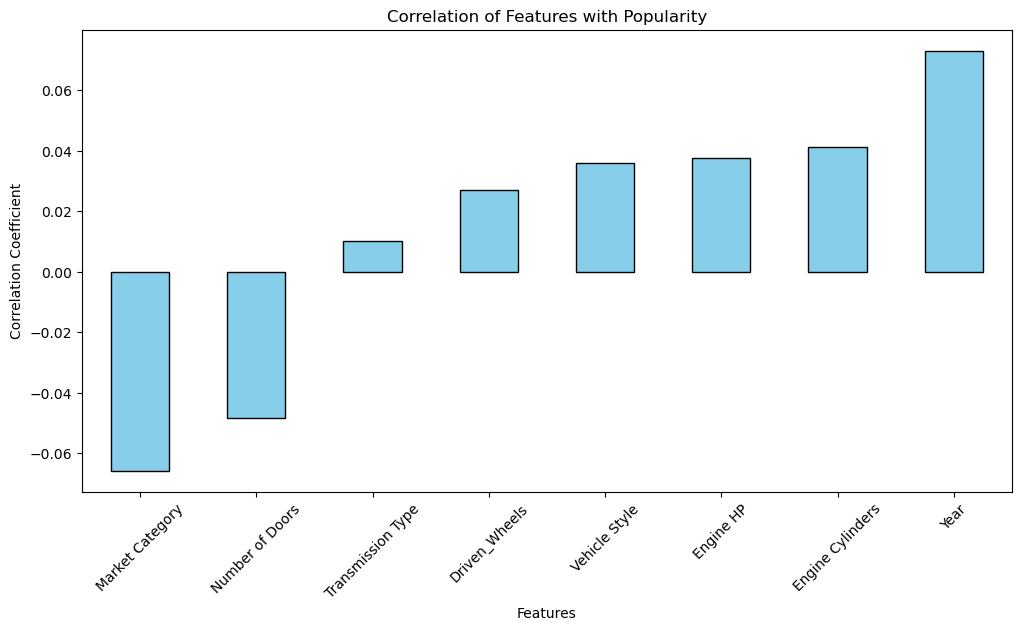

In [30]:
import matplotlib.pyplot as plt
#Encoding the data
encoded_data = cars_data.copy()


for column in selected_features:
    if encoded_data[column].dtype == 'object':
        encoded_data[column] = encoded_data[column].astype('category').cat.codes

#Correlation matrix
correlation_matrix = encoded_data.corr(numeric_only=True)

# Correlations with respect to 'Popularity'
feature_correlations = correlation_matrix['Popularity'][selected_features]

# Plotting the correlations
plt.figure(figsize=(12, 6))
feature_correlations.sort_values().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Correlation of Features with Popularity')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()


In [32]:
# Positive correlation features
positive_corr_features = feature_correlations[feature_correlations > 0].index.tolist()

#Positive correlation metrics
positive_corr_metrics = pd.DataFrame({
    'Feature': positive_corr_features,
    'Correlation with Popularity': feature_correlations[positive_corr_features]
}).reset_index(drop=True)


In [34]:
positive_corr_metrics


,Feature,Correlation with Popularity
0,Year,0.073049
1,Engine HP,0.037501
2,Engine Cylinders,0.041145
3,Transmission Type,0.010095
4,Driven_Wheels,0.026987
5,Vehicle Style,0.036024


In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
data_cleaned = encoded_data.dropna(subset=positive_corr_features + ['Popularity'])

#Test Train split
X_cleaned = data_cleaned[positive_corr_features]
y_cleaned = data_cleaned['Popularity']

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)

#Linerregression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

# Evaluateing the model
mse_cleaned = mean_squared_error(y_test, y_pred)
r2_cleaned = r2_score(y_test, y_pred)

mse_cleaned, r2_cleaned


(1927052.2453350003, 0.006071948565162355)

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

#Ridge regression model
ridge_regressor = Ridge()

#Parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag']
}

# Performing GridSearchCV
grid_search = GridSearchCV(estimator=ridge_regressor, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

#Best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

best_params, best_score, mse_best, r2_best


({'alpha': 100.0, 'solver': 'sag'},
 0.013909118753274875,
 1927106.264389418,
 0.006044086812255656)

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

#Random Forest Regressio0n
rf_regressor = RandomForestRegressor(random_state=42)

#Parameter grid for hyperparameter tuning
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_regressor, param_grid=param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and the best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

# Evaluate the best model on the test set
best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

best_params_rf, best_score_rf, mse_rf, r2_rf


({'max_depth': 20,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 200},
 0.7629228183117851,
 409782.5878533618,
 0.7886438159406453)

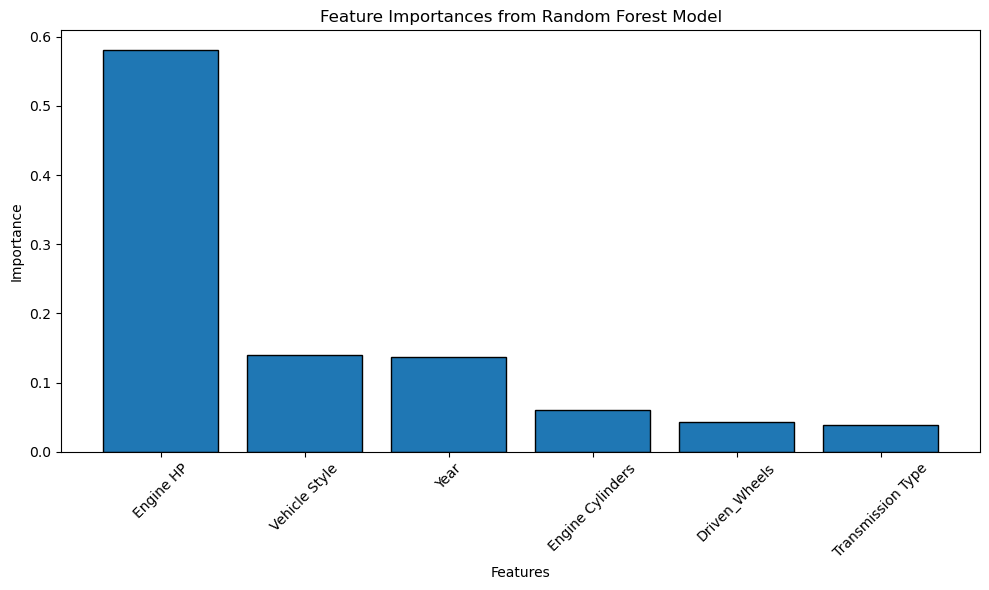

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

#Plot for better understanding
feature_importances = best_rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], edgecolor='black')
plt.title('Feature Importances from Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
